In [1]:
!pip install -q -U 'tensorflow-text==2.8.*'

     |████████████████████████████████| 4.9 MB 20.3 MB/s 
     |████████████████████████████████| 497.9 MB 4.7 kB/s 
     |████████████████████████████████| 5.8 MB 63.1 MB/s 
     |████████████████████████████████| 462 kB 67.2 MB/s 
     |████████████████████████████████| 1.4 MB 65.8 MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.3 MB 9.2 MB/s 
     |████████████████████████████████| 588.3 MB 7.1 kB/s 
     |████████████████████████████████| 118 kB 72.8 MB/s 
     |████████████████████████████████| 238 kB 68.5 MB/s 
     |████████████████████████████████| 1.3 MB 65.5 MB/s 
     |████████████████████████████████| 352 kB 73.6 MB/s 
     |████████████████████████████████| 5.8 MB 53.9 MB/s 
     |████████████████████████████████| 636 kB 77.0 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 38.2 MB 1.4 MB/s 
     |████████████████████████████████| 1.1 MB 56.6 MB/s 
     |████████████████████████████████| 439 kB 73.1 MB/s 
     |████████████████████████████████| 1.7 MB 65.6 MB/s 
     |████████████████████████████████| 6.0 MB 44.3 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import re
import time
import unicodedata
import datetime
import pathlib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers

import tensorflow_hub as hub
import tensorflow_models as tfm

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [5]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

In [6]:
# PARAMETRI GLOBALI
root_folder = 'drive/MyDrive/BERT/'

# DATI
data_folder_name = 'data'
train_filename = 'ita.txt'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit/transformer_without_encoder'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))) 

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights/transformer_without_encoder'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))
checkpoint_path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp.ckpt'))
log_weights = os.path.abspath(os.path.join(PATH_WEIGHTS, 'weights_25_epochs.h5'))

# MODELLO TOKENIZER
model_name = 'tokenizer_it_transformer_model'
tokenizer_folder_name = 'tokenizer'

TOKEN_PATH = os.path.abspath(os.path.join(root_folder, tokenizer_folder_name))
tokenizer_filenamepath = os.path.abspath(os.path.join(TOKEN_PATH, model_name))

In [7]:
# parametri per il modello
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 12992 # portato da 10.000 a 100.000
TRAIN = 10016

MAX_VOCAB_SIZE = 20000 # portato da 20.0000 a 200.000
EMBEDDING_DIM = 64  # --> 256  Densa non lineare relu --> 64  Densa non lineare relu (oppure Conv1D kernel=1)
HIDDEN_DIM = 1024 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
BUFFER_SIZE = 2000
EPOCHS = 25
MAX_SEQ_LENGTH = 16 # --> portare a 10 con layer 'lambda'[:,:10]

NUM_LAYERS = 4 # Numero di layer di Encoder e Decoder del Transformer
NUM_HEADS = 8 # Numero di meccanismi di multi-head attention
FF_DIM = 16 # Numero di celle dei Layer Feed Forward
DROPUOT = 0.1

LEARNING_RATE=0.0003

# IMPOSTO IL DEBUG A TRUE 
debug = True
training = True

In [8]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  
tfhub_handle_encoder =  'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
gs_folder_bert = 'gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12'
bert_vocab = os.path.join(gs_folder_bert, 'vocab.txt')

print('BERT model selected                : ', tfhub_handle_encoder)
print('Preprocessing model auto-selected  : ', tfhub_handle_preprocess)
print('BERT vocab                         : ', bert_vocab)

BERT model selected                :  https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected  :  https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
BERT vocab                         :  gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12/vocab.txt


## DATASET

### Caricamento Dati

In [9]:
# Caricamento dataset: frasi in inglese, frasi in italiano
df = pd.read_csv(
    train_filenamepath,
    sep="\t",
    header=None,
    names=[INPUT_COLUMN, TARGET_COLUMN],
    usecols=[0,1],
    nrows=NUM_SAMPLES
)

print(df.iloc[42:48], '\n')

# Preprocessing dei dati di Input
input_data = df[INPUT_COLUMN].tolist()

# Preprocessing dei dati Target con aggiunta del token di fine frase
target_data = df[TARGET_COLUMN].tolist()

train_input_data = input_data[:TRAIN]
train_target_data = target_data[:TRAIN]

test_input_data = input_data[TRAIN:]
test_target_data = target_data[TRAIN:]

print('-----------TRAIN SET--------------')
print(train_input_data[42:48])
print(train_target_data[42:48])
print('-----------TEST SET---------------')
print(test_input_data[42:48])
print(test_target_data[42:48])


     input       target
42  Do it.   Lo faccia.
43  Do it.   La faccia.
44  Do it.      Fatelo.
45  Do it.      Fatela.
46  Go on.  Vai avanti.
47  Go on.    Continua. 

-----------TRAIN SET--------------
['Do it.', 'Do it.', 'Do it.', 'Do it.', 'Go on.', 'Go on.']
['Lo faccia.', 'La faccia.', 'Fatelo.', 'Fatela.', 'Vai avanti.', 'Continua.']
-----------TEST SET---------------
["They've gone.", "They've gone.", "They've gone.", "They've gone.", "They've left.", "They've left."]
['Sono andati.', 'Loro sono andati.', 'Sono andate.', 'Loro sono andate.', 'Sono partiti.', 'Loro sono partiti.']


### Tokenizer

*   Per la parte di Encoder recupero la classe tfhub_handle_preprocess per tokenizzare le sequenze di input da passare al modello BERT
*   Per la parte di Decoder recupero la classe TokenizerCustom creata utilizzzando il set di dati a disposizione 

In [10]:
# Tokenizer Encoder
tokenizer_encoder = hub.KerasLayer(tfhub_handle_preprocess, name='Bert_Preprocessing')

# Tokenizer Decoder 
tokenizer_decoder = tf.saved_model.load(tokenizer_filenamepath)
tokenizer_decoder = tokenizer_decoder.it

### Creazione dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [11]:
def prepare_batch(en, it):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int64)
  en = tokenizer_encoder(en) # Output is ragged.
  # en = tf.concat([en, zero], 1)
  # en = en[:, :MAX_SEQ_LENGTH]     # Trim to MAX_TOKENS.
  # en = en.to_tensor()             # Convert to 0-padded dense Tensor

  it = tokenizer_decoder.tokenize(it)
  it_inputs = it[:, :-1].to_tensor()  # Drop the [END] tokens
  it_labels = it[:, 1:].to_tensor()   # Drop the [START] tokens
  
  it_inputs = tf.concat([it_inputs, zero], 1)
  it_inputs = it_inputs[:, :(MAX_SEQ_LENGTH)]

  it_labels = tf.concat([it_labels, zero], 1)
  it_labels = it_labels[:, :(MAX_SEQ_LENGTH)]

  return (en, it_inputs), it_labels

In [12]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [13]:
# Definizione del dataset
# [from_tensor_slices] permette di recuperare batch
# di esempi dai dataset di riferimento
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input_data, test_target_data))

# impostazione del recupero di esempi presi in maniera
# casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
train_dataset = make_batches(train_dataset)
test_dataset = make_batches(test_dataset)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [14]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (en_input, it_input), it_target in train_dataset.take(1):
  print('---------------------ENCODER  ----------------------------------')
  print(f'Shape                    : {en_input["input_word_ids"].shape}')
  print(f'Word Ids                 : {en_input["input_word_ids"][0, :MAX_SEQ_LENGTH]}')
  print(f'Input Mask               : {en_input["input_mask"][0, :MAX_SEQ_LENGTH]}')
  print(f'Type Ids                 : {en_input["input_type_ids"][0, :MAX_SEQ_LENGTH]}')  
  print('-------------------- DECODER -----------------------------------')
  print(f'Shape it input           : {it_input.shape}')
  print(f'Example it input         : {it_input[0]}')  
  print(f'Target Shape it input    : {it_target.shape}')
  print(f'Target Example it target : {it_target[0]}')  
  print('-------------------------------------------------------')

---------------------ENCODER  ----------------------------------
Shape                    : (32, 128)
Word Ids                 : [ 101 1045 4384 1012  102    0    0    0    0    0    0    0    0    0
    0    0]
Input Mask               : [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
-------------------- DECODER -----------------------------------
Shape it input           : (32, 16)
Example it input         : [   2   88  157   64 2661   11    0    0    0    0    0    0    0    0
    0    0]
Target Shape it input    : (32, 16)
Target Example it target : [  88  157   64 2661   11    3    0    0    0    0    0    0    0    0
    0    0]
-------------------------------------------------------


# TRANSFORMER

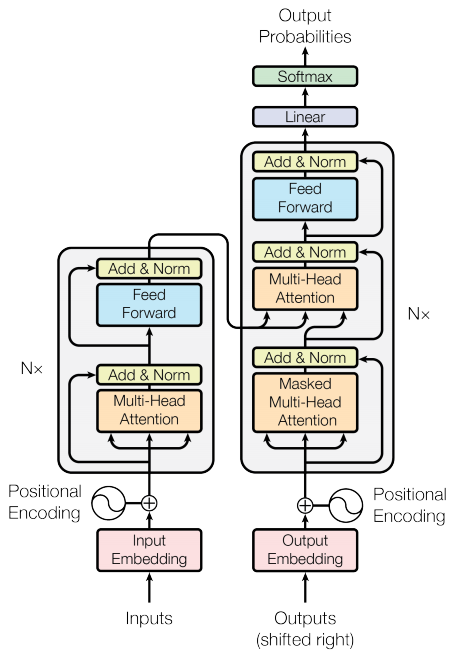

## ENCODER

Predispondo la classe necessaria per la costruzione dello strato di Encoder basato su BERT


In [15]:
class EncoderBert(layers.Layer):
  def __init__(self, bert_preprocess, bert_encoder, embedding_dim, max_len):
    super(EncoderBert, self).__init__()
    self.encoder = hub.KerasLayer(bert_encoder, name='BERT_encoder')
    self.conv_1 = tf.keras.layers.Conv1D(embedding_dim * 4, 1, activation='relu') 
    self.conv_2 = tf.keras.layers.Conv1D(embedding_dim, 1, activation='relu') 
    self.lambda_layer = tf.keras.layers.Lambda(lambda x: x[:,:max_len])
    self.max_len = max_len

  def call(self, x, debug=False):
    # x = self.preprocess(input_sequnces)

    if debug:
      print(f'****************** DEBUG ENCODER BERT ******************')
      print(f"First example")
      print(f'Keys                         : {list(x.keys())}')
      print(f'Shape                        : {x["input_word_ids"].shape}')
      print(f'Word Ids                     : {x["input_word_ids"][0, :self.max_len]}')
      print(f'Input Mask                   : {x["input_mask"][0, :self.max_len]}')
      print(f'Type Ids                     : {x["input_type_ids"][0, :self.max_len]}')
      
    # x = self.encoder(x)['sequence_output'] 
    # encoder_outputs stato intermedio di BERT prima che esegua la traduzione recuperare la metà della lunghezza
    x = self.encoder(x)['encoder_outputs'] 
    x = x[int(len(x) / 2) - 1]
    if debug:
      print()
      print(f'Encoder Outputs BERT Shape   : {x.shape}')
      print(f'Encoder Outputs BERT Values  : {x[0, :1, :self.max_len]}')

    x = self.conv_1(x)
    if debug:
      print()
      print(f'Sequence Conv1 Shape         : {x.shape}')

    x = self.conv_2(x)
    if debug:
      print(f'Sequence Conv2 Shape         : {x.shape}')

    x = self.lambda_layer(x)
    if debug:
      print(f'Sequence Lambda Layer        : {x.shape}')
      print()
      print(f'Sequence Outputs Values      : {x[0, 0, :self.max_len]}')      
      print('*********************************************************') 

    return x

In [16]:
encoder_bert = EncoderBert(tfhub_handle_preprocess, 
                           tfhub_handle_encoder, 
                           EMBEDDING_DIM, 
                           MAX_SEQ_LENGTH)

output_bert = encoder_bert(en_input, debug) 

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape                        : (32, 128)
Word Ids                     : [ 101 1045 4384 1012  102    0    0    0    0    0    0    0    0    0
    0    0]
Input Mask                   : [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                     : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[-0.02077313 -0.85555005 -0.35486484 -0.74006593 -0.04052219 -0.2325665
  -0.21788126 -0.40686315 -0.05877984 -1.2413253  -0.28136438  0.988265
   0.22450303  0.41294956 -0.2454491  -0.13678454]]

Sequence Conv1 Shape         : (32, 128, 256)
Sequence Conv2 Shape         : (32, 128, 64)
Sequence Lambda Layer        : (32, 16, 64)

Sequence Outputs Values      : [0.         0.         0.6802106  0.         0.         0.
 0.         0.         1.3555194  0.08124395 1.0345147  0.52

## DECODER

Predispongo le classi necessarie per la costruzione dello strato di DECODER

### Token and Position Embedding

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras

In [17]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x, debug=False):
    x = keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [18]:
token_position_it = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizer_decoder.get_vocab_size(), EMBEDDING_DIM)

inputs_decoder = token_position_it(it_input, debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 16
Sequence Shape                            : [32 16]
Shape TokenAndPositionEmbedding           : (32, 16, 64)
*********************************************************


### Layer Decoder

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

In [19]:
class Decoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DEC'):
    super(Decoder, self).__init__()
    self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.layernorm3 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, encoder_output, training=False, debug=False):
    attn_output1 = self.att1(query=inputs,
                             value=inputs, 
                             key=inputs, 
                             use_causal_mask=True)
    
    attn_output1 = self.dropout1(attn_output1)
    out1 = self.layernorm1(inputs + attn_output1)

    attn_output2 = self.att2(key=encoder_output, 
                             value=encoder_output, 
                             query=out1)
    
    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [20]:
decoder = Decoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_decoder = decoder(inputs=inputs_decoder, 
                          encoder_output=output_bert,  
                          training=training,
                          debug=debug)

******************* DEBUG DECODER ***********************
Input Shape                       : (32, 16, 64)
Shape Outputs Decoder             : (32, 16, 64)
*********************************************************


### Transformer

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras

In [21]:
class TransformerBlock(keras.Model):
  def __init__(self, 
               num_layers, 
               embed_dim, 
               num_heads, 
               ff_dim, 
               max_len,
               target_vocab_size,
               preprocess,
               encoder,
               rate=0.5):
    
    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers
    self.encoder_bert = EncoderBert(preprocess, 
                                    encoder, 
                                    embed_dim, 
                                    max_len)

    self.token_pos_dec = TokenAndPositionEmbedding(max_len, target_vocab_size, embed_dim)

    self.decoder = [Decoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training=False, debug=False):
    inputs_encoder, inputs_decoder  = inputs

    encoder_output = self.encoder_bert(inputs_encoder, debug) 
    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_decoder       : {inputs_decoder.shape}')      

    transformer_output = inputs_decoder
      
    for i in range(self.num_layers):
      transformer_output = self.decoder[i](inputs=transformer_output, 
                                           encoder_output=encoder_output, 
                                           training=training,
                                           debug=debug)

    logits = self.final_layer(transformer_output)

    if debug:
      print(f'Output Shape       : {logits.shape}')
      print(f'Output Transformer : {logits[0, :1, :12]}')    
      print(f'---------------------------------------------------------')

    return logits

In [22]:
transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizer_decoder.get_vocab_size(),
                               tfhub_handle_preprocess,
                               tfhub_handle_encoder,
                               DROPUOT)

transformer_output = transformer((en_input, it_input), 
                                 training=training,
                                 debug=debug)

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape                        : (32, 128)
Word Ids                     : [ 101 1045 4384 1012  102    0    0    0    0    0    0    0    0    0
    0    0]
Input Mask                   : [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                     : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[-0.02077313 -0.85555005 -0.35486484 -0.74006593 -0.04052219 -0.2325665
  -0.21788126 -0.40686315 -0.05877984 -1.2413253  -0.28136438  0.988265
   0.22450303  0.41294956 -0.2454491  -0.13678454]]

Sequence Conv1 Shape         : (32, 128, 256)
Sequence Conv2 Shape         : (32, 128, 64)
Sequence Lambda Layer        : (32, 16, 64)

Sequence Outputs Values      : [0.38756484 0.         0.         0.3176737  0.86347336 0.
 0.         0.5335588  0.7239782  0.         0.         0.84

In [23]:
transformer.summary()

Model: "transformer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_bert_1 (EncoderBert  multiple                 109695553 
 )                                                               
                                                                 
 token_and_position_embeddin  multiple                 594816    
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 DEC (Decoder)               multiple                  267856    
                                                                 
 DEC (Decoder)               multiple                  267856    
                                                                 
 DEC (Decoder)               multiple                  267856    
                                                 

### Addestramento

In [24]:
transformer.compile(
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(epsilon=1e-9, learning_rate=LEARNING_RATE),
    metrics=['accuracy'])

In [25]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [26]:
start = datetime.datetime.now()
history = transformer.fit(train_dataset,
                          epochs=EPOCHS,
                          validation_data=test_dataset,
                          callbacks=[tensorboard_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 1/25
313/313 [==============================] - 432s 1s/step - loss: 4.2214 - accuracy: 0.6792 - val_loss: 1.9166 - val_accuracy: 0.7046
Epoch 2/25
313/313 [==============================] - 430s 1s/step - loss: 1.4052 - accuracy: 0.8115 - val_loss: 1.4149 - val_accuracy: 0.8100
Epoch 3/25
313/313 [==============================] - 430s 1s/step - loss: 1.1154 - accuracy: 0.8391 - val_loss: 1.2421 - val_accuracy: 0.8254
Epoch 4/25
313/313 [==============================] - 431s 1s/step - loss: 0.9680 - accuracy: 0.8503 - val_loss: 1.1431 - val_accuracy: 0.8393
Epoch 5/25
313/313 [==============================] - 426s 1s/step - loss: 0.8591 - accuracy: 0.8610 - val_loss: 1.0767 - val_accuracy: 0.8434
Epoch 6/25
313/313 [==============================] - 427s 1s/step - loss: 0.7713 - accuracy: 0.8690 - val_loss: 1.0240 - val_accuracy: 0.8488
Epoch 7/25
313/313 [==============================] - 430s 1s/step - loss: 0.6953 - accuracy: 0.8768 - val_loss: 0.9958 - val_accuracy: 0.8523

### Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

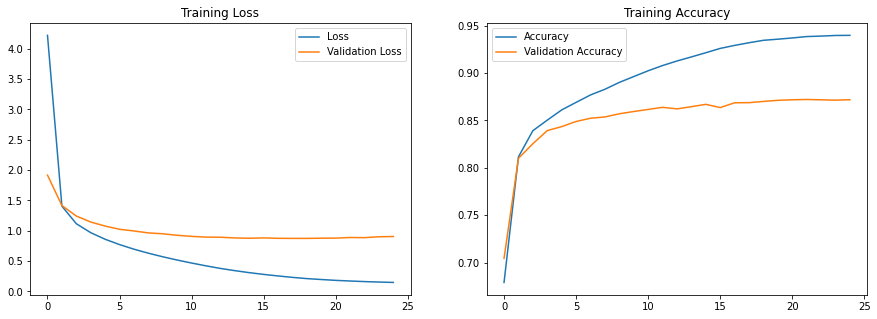

In [27]:
# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(history.history['loss'], label='Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(history.history['accuracy'], label='Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

### Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [28]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [32]:
class Translate:
  def __init__(self, transformer_block, tokenizer_encoder, tokenizer_decoder):
    self.transformer = transformer_block
    self.tokenizer_encoder = tokenizer_encoder
    self.tokenizer_decoder = tokenizer_decoder

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = input_data[np.random.choice(len(input_data))]
      print(input_text)

    # print(input_text)
    inputs_encoder = self.tokenizer_encoder(input_text)

    # print(inputs_encoder)
    
    start_end = self.tokenizer_decoder.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int64, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, start)     

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())
      # print('Output', output)
      transformer_output = transformer([inputs_encoder, output], 
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (K.argmax(transformer_output, axis=-1)).numpy()
      # preds = pred_values[0][predict.numpy()[0][0]]
      
      # print('predict',  predict)
      # print('predictions', transformer_output)
      # print('pred_values', pred_values[0][0])
      # print('predict[0]', pred_values[0][i])
      
  
      # print('Preds', preds)
      # print('Detokenize', (tokenizers.it.detokenize(pred_values)))
      # print('##########################')
    
      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])
      # output_array = output_array.write(i+1, predict[0])

      # termine del ciclo quando si incontra il token <end-of-sentence>
      # oppure la lunghezza massima prevista della sequenza
      # print(end)
      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizer_decoder.detokenize(output)[0]  

    tokens = tokenizer_decoder.lookup(output)[0]

    return text, tokens

In [33]:
test_sequences = [test_input_data[41], test_input_data[102], test_input_data[612], test_input_data[432], test_input_data[222]]

translate = Translate(transformer_block=transformer,
                      tokenizer_encoder=tokenizer_encoder,
                      tokenizer_decoder=tokenizer_decoder)

for test_sequence in test_sequences:
  text, token = translate.predict(tf.constant([test_sequence]), MAX_SEQ_LENGTH)

  print(f'{"Input:":15s}: {test_sequence}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  # print(f'tokens : {token}')
  # print(target_data[41])
  # break
  print('---------------------------------------------')

print(test_target_data[41])
print(test_target_data[102])
print(test_target_data[612])
print(test_target_data[432])
print(test_target_data[222])

Input:         : They're weak.
Prediction     : loro sono debole .
---------------------------------------------
Input:         : Tom can read.
Prediction     : tom sa leggere .
---------------------------------------------
Input:         : We all stood.
Prediction     : siamo in piedi .
---------------------------------------------
Input:         : Tom will die.
Prediction     : tom potrebbe morire .
---------------------------------------------
Input:         : Tom is going.
Prediction     : tom era andare .
---------------------------------------------
Loro sono deboli.
Tom può leggere.
Eravamo tutte in piedi.
Tom morirà.
Tom sta andando.


### Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
log_dir

In [ ]:
%tensorboard --logdir drive/MyDrive/BERT/logs/fit/20221026-134720